In [1]:
from Bio.SearchIO import HmmerIO
from Bio import AlignIO, SeqIO
import re 

import pandas as pd
import subprocess

from glob import glob
import os

from tqdm.notebook import tqdm

import pandas as pd
from addict import Dict
import sys
sys.path.append('../03_acetyl')
from funcs import *

from matplotlib_venn import venn2

import matplotlib
matplotlib.style.use('seaborn-whitegrid')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [2]:
PATHES = pd.read_csv('../gtdb_info/pathes.csv')
pd.options.display.max_colwidth = 120
PATHES.head(1)

,path,accession,assembly,kindom,species
0,/media/pc208/es/litvinanna/gtdb-202/genomic_files_reps/protein_faa_reps/archaea/GB_GCA_000008085.1_protein.faa,GB_GCA_000008085.1,GCA_000008085.1,archaea,Nanoarchaeum equitans


In [3]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8, progress_bar=True)
from tqdm import tqdm
tqdm.pandas()
from hmm_search_funcs_for_atpases import *

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
seq = next(get_seq_record(PATHES[PATHES.accession == 'GB_GCA_000007325.1'].path.iloc[0],'AE009951.2_920')).seq
print_seq(seq)

MDLLTAKTIVLGCSAVGAGLAMIAGLGPGIGEGYAAGKAVESVARQPEARGSIISTMILGQAVAESTGIYSLVIALILLYANPFLSKLG*

# [optioanl] deal with c

In [75]:
# c_dom = pd.concat([parse_hmmresults_dom(path) for path in tqdm(glob('hmmsearch_results/c_dom/*'))])
# c_dom.to_csv('hmmsearch_results/c_dom.csv', index = False)

Text(0.5, 0, 'bitscore')

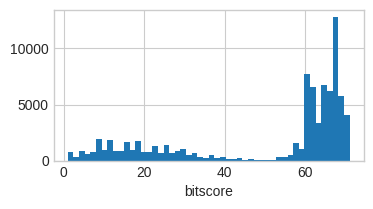

In [80]:
c_dom = pd.read_csv('hmmsearch_results/c_dom.csv')
c_dom.shape
c_dom.head(1)
c_dom.query_span.hist(bins = 50, figsize = (4, 2))
plt.xlabel('bitscore')

In [31]:
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, OPTICS

In [68]:
# clusters = SpectralClustering(3, n_jobs = 8, verbose = True).fit_predict(c_dom[['bitscore', 'query_span']])
# clusters = DBSCAN(1, n_jobs = 2).fit_predict(c_dom[['bitscore', 'query_span']])
# clusters = OPTICS().fit_predict(c_dom[['bitscore', 'query_span']])
# len(set(clusters))
# c_dom.plot.scatter('bitscore', 'query_span', s = 1,alpha = 0.1, c = clusters, cmap = 'viridis')
# plt.hlines(45, 0, 100, color = 'black')

In [130]:
# _, axs = plt.subplots(2, 2, figsize  = (8, 6), #sharey = True, 
#                      gridspec_kw={'width_ratios': [2, 1], 'height_ratios': [2, 1]})
# axs = axs.flatten()

# c_dom.plot.scatter('bitscore', 'query_span', s = 1,alpha = 0.1, ax = axs[0])
# axs[0].vlines(40, 0, 80,  color = 'black', linewidth = 1)
# axs[0].hlines(45, -20, 110, color = 'black',linewidth = 1)

# c_dom.query_span.hist(bins = 50, ax = axs[1], orientation='horizontal')
# axs[1].hlines(45, 0, 14e3, color = 'black',linewidth = 1)
# axs[1].set_xlabel('#N')

# c_dom.bitscore.hist(bins = 50, ax = axs[2],)
# # axs[2].hlines(45, 0, 14e3, color = 'black',linewidth = 1)
# # axs[2].set_xlabel('#N')

In [158]:
# import seaborn as sns

# plot = sns.jointplot(x = 'bitscore', y = 'query_span', data=c_dom, 
#                      kind = 'scatter', height = 4, s = 1)
# plot.ax_joint.axvline(x=40, color = 'black', linewidth = 1)
# plot.ax_joint.axhline(y=45, color = 'black', linewidth = 1)

In [489]:
def group_c_subunit(df):
    new_line = pd.Series(dtype = float)
    new_line['c_domains_old'] = len(df)
    
    df = df[df.query_span > 45]
    
    intersection = False
    df.sort_values('query_start',ascending=True, inplace=True)
    current = 0
    for _, (start, end) in df[['query_start', 'query_end']].iterrows():
        current = current or (start > current)
        current = end
    new_line['intersection'] = intersection
    
    new_line['bitscore']  = df.bitscore.max()
    new_line['bitscore_mean']  = df.bitscore.mean()
    new_line['c_domains'] = len(df)
    return new_line

In [491]:
# c_dom[c_dom.fasta_id ==  'PDTW01000008.1_10'].groupby(['genome', 
#                     'fasta_id', 'ID', 'start', 'end', 'strand', 
#                     'partial', 'start_type', 'rbs_motif', 'rbs_spacer', 'gc_cont'])\
# .progress_apply(group_c_subunit)

In [492]:
c_new = c_dom.groupby(['genome', 
                    'fasta_id', 'ID', 'start', 'end', 'strand', 
                    'partial', 'start_type', 'rbs_motif', 'rbs_spacer', 'gc_cont'])\
.progress_apply(group_c_subunit)
c_new = c_new.reset_index()
# 330 - 350 it/s
c_new.to_csv('hmmsearch_results/c_dom_merged.csv', index = False)

100%|███████████████████████████████████████████████████████████████████████████████████| 58963/58963 [03:09<00:00, 311.43it/s]


In [438]:
# c_new.sort_values('bitscore_mean', inplace = True)

# import matplotlib.pyplot as plt
# plt.figure(figsize = (15, 10))
# plt.scatter(x = c_new.fasta_id, y = c_new.bitscore,      s = 0.5)
# plt.scatter(x = c_new.fasta_id, y = c_new.bitscore_mean, s = 0.5)
# plt.xticks([])
# plt.show()

## research c

In [4]:
c_dom   = pd.read_csv('hmmsearch_results/c_dom.csv')
c_whole = pd.read_csv('hmmsearch_results/c_dom_merged.csv')
c_whole['prl'] = (c_whole.end - c_whole.start + 1) / 3

In [5]:
c_whole.intersection.unique()

array([0.])

In [6]:
 c_whole[c_whole['prl'] > 6000]

,genome,fasta_id,ID,start,end,strand,partial,start_type,rbs_motif,rbs_spacer,gc_cont,c_domains_old,intersection,bitscore,bitscore_mean,c_domains,prl
1604,GB_GCA_001784175.1,MFPR01000019.1_1,19_1,1,21603,1,10,Edge,None,None,0.636,12.0,0.0,NaN,NaN,0.0,7201.0


In [7]:
c_whole = c_whole[c_whole['prl'] < 6000]

In [ ]:
c_dom

In [6]:
# c_whole.c_domains.value_counts().sort_index()

In [7]:
# c_whole[c_whole.bitscore < 40].c_domains.value_counts().sort_index()

In [8]:
# c_whole[c_whole.bitscore > 40].c_domains.value_counts().sort_index()

In [500]:
# # c_whole[c_whole.c_domains >= 7].plot.scatter('c_domains', 'prl')
# c_whole.plot.scatter('c_domains', 'prl')
# plt.plot(np.arange(0, 14, 1), np.arange(0, 14, 1)*70, color = 'red')
# plt.ylim(0, 1000)

In [504]:
# to_check = c_whole[c_whole.c_domains >= 7].fasta_id.to_list()
# print(len(to_check))
# i = 3
# c_dom[c_dom.fasta_id == to_check[i]]

# [optional] Mulk c A type

In [61]:
# ck_dom = pd.concat([parse_hmmresults_dom(path) for path in tqdm(glob('hmmsearch_results/mulk_v_type_ck_dom/*'))])
# ck_dom.to_csv('hmmsearch_results/mulk_v_type_ck_dom.csv', index = False)

In [159]:
# ck_dom = pd.read_csv('hmmsearch_results/mulk_v_type_ck_dom.csv')
# ck_dom.shape
# ck_dom.head(1)
# ck_dom.query_span.hist(bins = 100)

In [546]:
c_new = ck_dom.groupby(['genome', 
                    'fasta_id', 'ID', 'start', 'end', 'strand', 
                  'partial', 'start_type', 'rbs_motif', 'rbs_spacer', 'gc_cont'])\
.progress_apply(group_c_subunit)
c_new = c_new.reset_index()
# 330 - 350 it/s
c_new.to_csv('hmmsearch_results/mulk_v_type_ck_dom_merged.csv', index = False)

100%|███████████████████████████████████████████████████████████████████████████████████| 60127/60127 [03:13<00:00, 310.45it/s]


In [547]:
c_new = pd.read_csv('hmmsearch_results/mulk_v_type_ck_dom_merged.csv')

In [75]:
# c_new.sort_values('bitscore_mean', inplace = True)
# import matplotlib.pyplot as plt
# plt.figure(figsize = (15, 5))
# plt.scatter(x = c_new.fasta_id, y = c_new.bitscore, s = 0.5, c = 'blue')
# plt.scatter(x = c_new.fasta_id, y = c_new.bitscore_mean, s = 0.5, c = 'orange')
# plt.xticks([])
# plt.show()

In [76]:
# c_new.c_domains.value_counts()

# Compare F and V

In [16]:
cF = pd.read_csv('hmmsearch_results/c_dom_merged.csv')
cA = pd.read_csv('hmmsearch_results/mulk_v_type_ck_dom_merged.csv')

cF = cF.add_suffix('_F')
cA = cA.add_suffix('_A')

assert cF.fasta_id_F.nunique() == cF.shape[0]
assert cA.fasta_id_A.nunique() == cA.shape[0]

c = cF.merge(cA, left_on = 'fasta_id_F', right_on = 'fasta_id_A', how = 'outer')
print(c.shape)

c['genome'] = c.genome_F.combine_first(c.genome_A)
c = c.merge(PATHES, left_on = 'genome', right_on = 'accession')

c.bitscore_F = c.bitscore_F.fillna(0)
c.bitscore_A = c.bitscore_A.fillna(0)

(67853, 32)


In [19]:
(cF.c_domains_F == 0).sum(), (cA.c_domains_A == 0).sum()

(5943, 8028)

In [11]:
((c.c_domains_F == 0) &  (c.c_domains_A == 0)).sum()

361

In [12]:
print('A > F ', (c.c_domains_A >  c.c_domains_F).sum())
print('A = F' , (c.c_domains_A == c.c_domains_F).sum())
print('A < F ', (c.c_domains_A <  c.c_domains_F).sum())

A > F  1710
A = F 49186
A < F  341


Text(0.5, 0, 'bitscore_F')

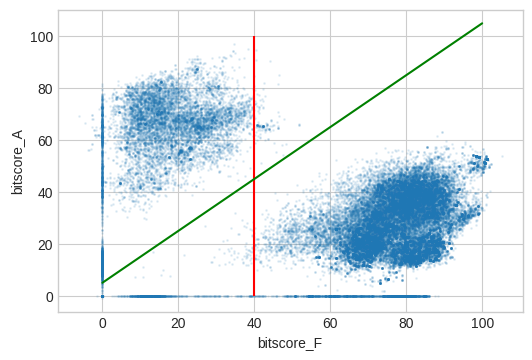

In [23]:
# args = {'s':1, 'c':  'bitscore_mean_F', 'cmap' : 'viridis', 'vmin':0, 'vmax':100, }
c.plot.scatter('bitscore_F', 'bitscore_A', alpha = 0.1, s = 1)
plt.vlines(40, 0, 100, color = 'red')
plt.plot ([0, 100],[5, 105], color = 'green')
plt.gca().set_xlabel('bitscore_F')

In [28]:
F_ind = (c.bitscore_F >  (c.bitscore_A - 5)) & (c.bitscore_F > 10)
c.at[F_ind, 'inf_type'] = 'F'

A_ind = (c.bitscore_F <= (c.bitscore_A - 5)) &  (c.bitscore_A >10)
c.at[A_ind, 'inf_type'] = 'A'

In [38]:
c.inf_type.value_counts()

F    43572
A    10744
Name: inf_type, dtype: int64

In [39]:
c.inf_type.isna().sum()

13537

In [30]:
# c.inf_type.isna().sum()

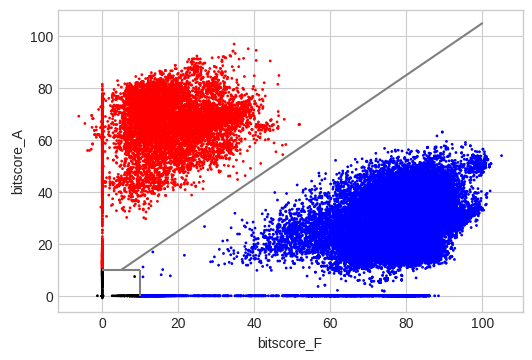

In [31]:
df = c
df.plot.scatter('bitscore_F', 'bitscore_A', 
                alpha = 1, 
                s = 1, 
                c = df.inf_type.map({'F': 'blue', 'A': 'red', np.nan:'black'}))
plt.plot([5, 100],[10, 105], color = 'grey')
plt.hlines(10, 0, 10, color = 'grey')
plt.vlines(10, 0, 10, color = 'grey')

In [32]:
# research_df = df[(df.bitscore_A == 0) & (df.bitscore_F<50)]
# # print(research_df.c_domains_F.value_counts())
# write_records(research_df, 
#               fasta_id = 'fasta_id', 
#               path = 'path', 
#               filename = f'alignments/c_A0_0_50.fasta',
#               description = 'description')

In [41]:
make_description(df, ['bitscore_F', 'kindom', 'species'], 'description')

In [45]:
# pd.options.display.max_columns = 50
# df.head()

In [44]:
df[df.inf_type == 'F'].c_domains_F.value_counts()

1.0     43242
2.0       126
4.0       117
3.0        62
5.0        13
6.0         8
7.0         2
8.0         1
12.0        1
Name: c_domains_F, dtype: int64

In [50]:
# research_df = df[(df.inf_type == 'F' ) & (df.c_domains_F ==1)]
# write_records(research_df, 
#               fasta_id = 'fasta_id_F', 
#               path = 'path', 
#               filename = f'alignments/cF_one.fasta',
#               description = 'description')

In [48]:
align_hmm('hmms/c.hmm', 'alignments/cF_one.fasta', 'alignments/cF_one.fasta_aln')

In [58]:
research_df = df[(df.inf_type == 'F' ) & (df.c_domains_F ==1)]

In [5]:
# research_df['prl'] = (research_df.end_F - research_df.start_F + 1) / 3

In [70]:
# research_df.prl.hist(bins = 50)
# plt.yscale('log')

In [72]:
a = AlignIO.read( 'alignments/cF_one.fasta_aln', 'fasta')

In [78]:
for i in a:
    if not i.id in research_df[research_df.prl > 500].fasta_id_F.to_list():

In [99]:
ok_list = research_df[research_df.prl < 500].fasta_id_F.to_list()
x = [i for i in a if i.id in ok_list]

In [102]:
from Bio.Align import MultipleSeqAlignment
with  open('alignments/cF_one_short.fasta_aln', 'w') as file:
    AlignIO.write(MultipleSeqAlignment(x), file, 'fasta')

In [104]:
! trimal -noallgaps -in alignments/cF_one_short.fasta_aln -out alignments/cF_one_short.fasta_aln

In [106]:
a = AlignIO.read( 'alignments/cF_one_short.fasta_aln', 'fasta')

In [111]:
print_seq(a[0].seq[390:600].replace('-',''))

gtasiIISGLTIAIGSIGPAVGESWALSRALSAIAQQPDEANTITRTLFVGLAMIESTA

In [1]:
# from collections import Counter
# print(Counter(a[:, 511])) # R
# print(Counter(a[:, 516])) # Q
# print(Counter(a[:, 521])) # P

In [2]:
# print(Counter(a[:, 590])) # E/D

In [136]:
from tqdm import tqdm

In [152]:
features = []
for i in tqdm(a):
    features.append([
        i.id,
        i[590] in ['E', 'D'],
        i[436] in ['Q', 'E'],
        i[596] in ['S', 'T'],
        i[598] in ['S', 'T'],
        i[604] in ['Y'],
        i[587],
    ])

100%|████████████████████████████████████████████████████████████████████████████████| 43162/43162 [00:00<00:00, 103084.69it/s]


In [153]:
spec_data = pd.DataFrame(features, columns = ['fasta_id', 'cat', 'qe', 'st1', 'st2', 'y', '18'])

In [154]:
spec_data.cat.sum()

42740

In [155]:
spec_data[['cat', 'qe', 'st1', 'st2', 'y']].all(axis = 1).sum()

3279

In [158]:
spec_data['sodium'] = spec_data[['cat', 'qe', 'st1', 'st2', 'y']].all(axis = 1)

In [161]:
spec_data['proton'] = spec_data.cat &~spec_data.sodium

In [4]:
# spec_data[spec_data['sodium'] ]['18'].value_counts()

In [3]:
# spec_data[spec_data['sodium']].fasta_id

In [3]:
# spec_data.to_csv('specificity_data.csv')
import pandas as pd
spec_data = pd.read_csv('specificity_data.csv')

In [5]:
spec_data.sodium.sum()

3279

In [6]:
spec_data.proton.sum()

39461

## Use enzymes data


In [167]:
final = pd.read_csv('genomes_info_F_enz_v1.csv')
final.enz.nunique()

/home/pc208/bioinformatic_soft/yes/envs/zlitvinanna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


44832

In [526]:
# final = final[final.enz.notna()]
# for i, (n, df) in tqdm(enumerate(final.groupby('enz'))):
#     final.at[df.index, 'enz2'] = i
# final['prl'] = (final.end - final.start + 1) / 3
final_c = final[final.subunit == 'c'].copy()

In [516]:
cols = [ 'ID', 'partial',  'bitscore', 
        'subunit', 'N', 'bitscore_mean', 'c_domains',
         'opt', 'enzt', 'step', 'enz2', 
    'prl','start', 'end', 'strand',
 'genome', 'fasta_id', 'operons','evalue','logevalue',]

In [515]:
# from matplotlib_venn import venn2, venn2_unweighted
# venn2_unweighted([set(final_c.fasta_id), set(c[c.c_domains_F == 1].fasta_id_F)], 
#      set_labels = ['final c', 'c_domains_F == 1'])

In [529]:
# final_c.drop(['c_domains'], inplace = True, axis = 1)
final_c = final_c.merge(c_whole[['fasta_id', 'c_domains']])

In [223]:
pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 50

In [534]:
# final_c[final_c.c_domains >4] # выглядит окей
# final_c[final_c.c_domains == 4][cols] # выглядит окей
# final_c[final_c.c_domains == 3][cols] # выглядит окей

In [541]:
final_c[final_c['enzt'] == 'N'].c_domains.value_counts()

1.0    2752
Name: c_domains, dtype: int64

In [544]:
final_c[final_c.c_domains>=5][cols]

,ID,partial,bitscore,subunit,N,bitscore_mean,c_domains,opt,enzt,step,enz2,prl,start,end,strand,genome,fasta_id,operons,evalue,logevalue
2220,38_10,0,67.7,c,10,59.362500,8.0,acDbA,acDbA_GBE,inf_whole,24164.0,614.0,6892,8733,1,GB_GCA_902772755.1,CACYCD010000038.1_10,CACYCD010000038.1+0,NaN,NaN
5205,66_12,0,59.1,c,12,49.660000,5.0,single_operon,single_operon,single_operon,20817.0,436.0,13299,14606,1,GB_GCA_002315335.1,DCGW01000054.1_12,DCGW01000054.1+0,NaN,NaN
5229,38_13,0,55.1,c,13,47.120000,5.0,single_operon,single_operon,single_operon,16135.0,437.0,13477,14787,-1,GB_GCA_002315385.1,DCHZ01000004.1_13,DCHZ01000004.1-0,NaN,NaN
7525,56_9,0,61.9,c,9,52.716667,6.0,single_operon,single_operon,single_operon,25699.0,488.0,6951,8414,-1,GB_GCA_011372875.1,DSAD01000283.1_9,DSAD01000283.1-0,NaN,NaN
7538,38_12,0,70.5,c,12,54.466667,6.0,single_operon,single_operon,single_operon,27308.0,484.0,10782,12233,-1,GB_GCA_011046135.1,DSBG01000145.1_12,DSBG01000145.1-0,NaN,NaN
9903,20_3,0,62.8,c,3,55.483333,6.0,acb,_acb_AG_BE,inf_partial,23265.0,451.0,1072,2424,1,GB_GCA_013368515.1,JABWCI010000017.1_3,JABWCI010000017.1+0,NaN,NaN
11910,1_42,0,57.2,c,42,41.157143,7.0,cab,_cab_AG_BE,inf_partial,24937.0,525.0,41492,43066,-1,GB_GCA_003260325.1,MOLU01000001.1_42,MOLU01000001.1-2.0,NaN,NaN
17722,1_602,0,58.8,c,602,42.342857,7.0,cab,_b_cab_AG_BE,inf_partial,18160.0,522.0,628085,629650,-1,RS_GCF_002761215.1,NZ_CP017714.1_602,NZ_CP017714.1-2.0,NaN,NaN
18991,1_102,0,72.2,c,102,68.000000,5.0,single_operon,single_operon,single_operon,18683.0,388.0,102749,103912,-1,RS_GCF_005601135.1,NZ_CP039381.1_102,NZ_CP039381.1-0.0,NaN,NaN
35429,9_10,0,70.6,c,10,55.158333,12.0,acb,_acb_AG_BE,inf_partial,31961.0,897.0,7379,10069,1,GB_GCA_002749055.1,PDTW01000008.1_10,PDTW01000008.1+0,NaN,NaN


# Read data

In [75]:
df = pd.read_csv('hmmsearch_results/c_dom_merged.csv') 
print(df.shape)
df.head(1)

(58963, 16)


,genome,fasta_id,ID,start,end,strand,partial,start_type,rbs_motif,rbs_spacer,gc_cont,c_domains_old,intersection,bitscore,bitscore_mean,c_domains
0,GB_GCA_000007325.1,AE009951.2_226,1_226,238008,238490,-1,0,ATG,GGA/GAG/AGG,5-10bp,0.342,2.0,0.0,10.9,8.6,2.0


In [7]:
# df.bitscore.hist(bins = 100)

In [77]:
df = df.merge(PATHES, left_on = 'genome', right_on = 'accession')
print(df.shape)
df.head(1)

(58963, 21)


,genome,fasta_id,ID,start,end,strand,partial,start_type,rbs_motif,rbs_spacer,...,c_domains_old,intersection,bitscore,bitscore_mean,c_domains,path,accession,assembly,kindom,species
0,GB_GCA_000007325.1,AE009951.2_226,1_226,238008,238490,-1,0,ATG,GGA/GAG/AGG,5-10bp,...,2.0,0.0,10.9,8.6,2.0,/media/pc208/es/litvinanna/gtdb-202/genomic_files_reps/protein_faa_reps/bacteria/GB_GCA_000007325.1_protein.faa,GB_GCA_000007325.1,GCA_000007325.1,bacteria,Fusobacterium nucleatum


In [78]:
make_description(df, ['bitscore', 'c_domains', 'kindom', 'species'], 'description')

In [79]:
df.c_domains.value_counts().sort_index()

0.0      5943
1.0     49301
2.0      3439
3.0        99
4.0       125
5.0        17
6.0        28
7.0         2
8.0         1
9.0         1
11.0        2
12.0        4
13.0        1
Name: c_domains, dtype: int64

In [80]:
for n in [3, 4]:
    write_records(df[df.c_domains == n], 
                  fasta_id = 'fasta_id', 
                  path = 'path', 
                  filename = f'alignments/c_sh{n}.fasta',
                  description = 'description')

100%|█████████████████████████████████████████████████████████████| 124/124 [00:04<00:00, 28.04it/s]


In [71]:
# write_records(df[df.bitscore > 40], 
#               fasta_id = 'fasta_id', 
#               path = 'path', 
#               filename = 'alignments/c_40_max.fasta',
#               description = 'description')

In [72]:
# write_records(df[df.bitscore <= 40], 
#               fasta_id = 'fasta_id', 
#               path = 'path', 
#               filename = 'alignments/c_min_40.fasta',
#               description = 'description')

In [20]:
align_hmm('hmms/c.hmm', 'alignments/c_40_max.fasta', 'alignments/c_40_max.fasta_aln')

In [21]:
align_hmm('hmms/c.hmm', 'alignments/c_min_40.fasta', 'alignments/c_min_40.fasta_aln')

In [22]:
sort_alignment('alignments/c_40_max.fasta_aln', 1)

In [23]:
sort_alignment('alignments/c_min_40.fasta_aln', 1)

In [73]:
# df.c_domains.value_counts()